# <div align="center">Analysis and modeling of whether Americans vote or not</div> #


**<div align="center">Barrett Nibling</div>**
**<div align="center">bnibling@gmail.com</div>**

# Background

Every 2 years, a majority of American adults find themselves in the same situation come November 3rd with a decision whether or not to exercise one of their fundamental rights as a citizen in this country, voting in either the presidential and midterm elections. And for each election, millions of Americans choose the latter and decide to not cast a ballot. In fact, according to [MIT's Election Data + Science Lab](https://electionlab.mit.edu/research/voter-turnout), anywhere between 35 and 60 percent of the eligible voters in this country decide to abstain from voting come election day, with this figure varying based on numerous demographic features. 

So, the questions are: 
1. What makes people decided to vote or not for any given election? 

2. Can we predict who will vote and who will not vote from demographic and survey data? 

# Data

This notebook uses the polling data used for the Fivethirtyeight.com article, [Why Many Americans Don't Vote](https://projects.fivethirtyeight.com/non-voters-poll-2020-election/), that was provided by Ipsos. 

In the polling, approximately 8000 respondents were surveyed and then matched to voter file records by Aristole to determine their voting history, which reduced the number of responses to 5836.

The data includes basic demographic data:
  1. Age
  2. Gender
  3. Education
  4. Race
  5. Income

And includes responses to 33 topics about voting, government, and other political beliefs. 

The dataset and meta data (survey) can be found at:
 https://github.com/fivethirtyeight/data/tree/master/non-voters

# Import libraries

In [1]:
!pip install xgboost
!pip install scikit-optimize
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /opt/anaconda3/lib/python3.8/site-packages (0.7.0)


In [2]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scipy import stats

from imblearn.combine import SMOTEENN

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    mean_absolute_error,
    plot_confusion_matrix,
    classification_report,
)

from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Cleaning and Feature Engineering

Read in csv file as a pandas DataFrame

In [3]:
url = './nonvoters_data.csv'
data = pd.read_csv(url)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5836 entries, 0 to 5835
Columns: 119 entries, RespId to voter_category
dtypes: float64(23), int64(91), object(5)
memory usage: 5.3+ MB


Drop irrelevant features, namely ones with useless data, incomplete values, or feature dependent on other questions in the survey.

In [5]:
#Columns to Drop
#ID, weight, US citizen, Have you already voted, Political party (based on Q30)
drop_list = ['RespId','weight','Q1','Q21','Q22','Q31','Q32','Q33']

#Thoughts on the two parties
question_14 = ['Q14']
question_15 = ['Q15']

#Questions about whether participants voted in past elections
question_26 = ['Q26']
question_27 = ['Q27_1','Q27_2','Q27_3','Q27_4','Q27_5','Q27_6']
question_28 = ['Q28_1','Q28_2','Q28_3','Q28_4','Q28_5','Q28_6','Q28_7','Q28_8']
question_29 = ['Q29_1','Q29_2','Q29_3','Q29_4','Q29_5','Q29_6','Q29_7','Q29_8','Q29_9','Q29_10']

#`Other` option for 'What do you think would get more people to vote?' 
question_19_10 = ['Q19_10']

#Trump vs Biden
question_23 = ['Q23']

In [6]:
data.drop(drop_list, 1, inplace=True)
data.drop(question_14+question_15, 1, inplace=True)
data.drop(question_26+question_27+question_28+question_29, 1, inplace=True)
data.drop(question_19_10, 1, inplace=True)
data.drop(question_23, 1, inplace=True)

Organize features by type: Ordinal, Binary, Multi-class

In [7]:
#How important? (Ordinal)
question_2 = ['Q2_1', 'Q2_2', 'Q2_3', 'Q2_4', 'Q2_5', 'Q2_6', 'Q2_7', 'Q2_8', 'Q2_9', 'Q2_10']
#Agree or Disagree (Ordinal)
question_3 = ['Q3_1', 'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5', 'Q3_6']
#Impact (Ordinal)
question_4 = ['Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6']
#Politician like you? (Ordinal)
question_6 = ['Q6']
#Trust (Ordinal)
question_8 = ['Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q8_9']
#Way of governing (Ordinal)
question_9 = ['Q9_1', 'Q9_2', 'Q9_3', 'Q9_4']
#Ease of voting (Ordinal)
question_16 = ['Q16']
#Voting confidence (Ordinal)
question_17 = ['Q17_1', 'Q17_2', 'Q17_3', 'Q17_4']
#Following the 2020 election (Ordinal)
question_25 = ['Q25']

In [8]:
#Does presidential election matter? (Binary)
question_5 = ['Q5']
#U.S. government needs changes? (Binary)
question_7 = ['Q7']
#Various conditions (Binary )
question_10 = ['Q10_1', 'Q10_2', 'Q10_3', 'Q10_4']
question_11 = ['Q11_1', 'Q11_2', 'Q11_3', 'Q11_4', 'Q11_5', 'Q11_6']
question_18 = ['Q18_1', 'Q18_2', 'Q18_3', 'Q18_4', 'Q18_5', 'Q18_6', 'Q18_7', 'Q18_8', 'Q18_9', 'Q18_10']
#Registered to vote (Binary)
question_20 = ['Q20']

In [9]:
#What do you think would get more people to vote? (Binary- Yes or Blank)
question_19 = ['Q19_1','Q19_2','Q19_3','Q19_4','Q19_5','Q19_6','Q19_7','Q19_8','Q19_9']
#Preferred voting method (Categorical)
question_24 = ['Q24']
#Political party affiliation (Categorical)
question_30 = ['Q30']

Map the values for better analysis. 

Ordinal value ordering will be flipped 1-4:4-1 to better represent the data.

Binary values will be made either 0 or 1

Multi-class values will be properly encoded for future One-hot encoding.

All -1 values will be replaced with NaN values to be dropped.

In [10]:
df_encoded = data.copy()

In [11]:
ordinal_mapping = {1:4, 2:3, 3:2, 4:1, -1:np.nan}
bi_mapping = {1:1, 2:0, -1:np.nan}

In [12]:
df_encoded[question_2] = df_encoded[question_2].replace(ordinal_mapping)
df_encoded[question_3] = df_encoded[question_3].replace(ordinal_mapping)
df_encoded[question_4] = df_encoded[question_4].replace(ordinal_mapping)
df_encoded[question_6] = df_encoded[question_6].replace(ordinal_mapping)
df_encoded[question_8] = df_encoded[question_8].replace(ordinal_mapping)
df_encoded[question_9] = df_encoded[question_9].replace(ordinal_mapping)
df_encoded[question_16] = df_encoded[question_16].replace(ordinal_mapping)
df_encoded[question_17] = df_encoded[question_17].replace(ordinal_mapping)
df_encoded[question_25] = df_encoded[question_25].replace(ordinal_mapping)

df_encoded[question_5] = df_encoded[question_5].replace(bi_mapping)
df_encoded[question_7] = df_encoded[question_7].replace(bi_mapping)
df_encoded[question_10] = df_encoded[question_10].replace(bi_mapping)
df_encoded[question_11] = df_encoded[question_11].replace(bi_mapping)
df_encoded[question_18] = df_encoded[question_18].replace(bi_mapping)
df_encoded[question_20] = df_encoded[question_20].replace(bi_mapping)

df_encoded[question_19] = df_encoded[question_19].replace({1:1, -1:0})

In [13]:
q24_mapping = {1:'Mail-in', 2:'Early In-person', 3:'In-person', 4:'Other', -1:np.nan}
df_encoded[question_24] = df_encoded[question_24].replace(q24_mapping)

q30_mapping = {1:'Republican', 2:'Democrat', 3:'Independent', 4:'Other', 5:'No preference', -1:np.nan}
df_encoded[question_30] = df_encoded[question_30].replace(q30_mapping)

In [14]:
df_encoded.dropna(0, inplace=True)

Split features and the target variable.

Finish encoding of categorical values.

In [15]:
X = df_encoded.drop('voter_category', 1)
y = df_encoded['voter_category']

In [16]:
X_cat = pd.get_dummies(X.select_dtypes(include='O'), drop_first=True)

In [17]:
X = pd.concat([X.select_dtypes(exclude='O'), X_cat], 1)

In [18]:
y.value_counts()

sporadic        2257
always          1600
rarely/never    1244
Name: voter_category, dtype: int64

In [19]:
voter_map = {'always':0, 'sporadic':0, 'rarely/never':1}
y = y.replace(voter_map)
y.value_counts()

0    3857
1    1244
Name: voter_category, dtype: int64

Check for Collinearity in the feature variables and drop any above 0.8

In [20]:
corr_table = pd.melt(X.corr())
corr_table = corr_table[corr_table['value'] != 1.0]
corr_table['value'] = np.abs(corr_table['value'])
corr_table.sort_values('value', ascending=False).head(10)

,variable,value
278,Q2_4,0.706598
458,Q2_6,0.706598
921,Q3_1,0.704708
1011,Q3_2,0.704708
1655,Q4_3,0.671211
1565,Q4_2,0.671211
1473,Q4_1,0.649982
1563,Q4_2,0.649982
1214,Q3_4,0.631016
2834,Q8_7,0.631016


See if there are any features with strong correlation with the target.

In [21]:
corr_target = np.abs(X.corrwith(y)).sort_values(ascending=False)
corr_target[:10]

Q20                  0.471996
Q2_1                 0.401445
Q25                  0.313792
ppage                0.312707
Q2_2                 0.255542
Q2_3                 0.247786
Q30_No preference    0.233360
Q2_5                 0.227651
Q5                   0.225046
Q9_1                 0.213064
dtype: float64

# Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
smote = SMOTEENN(sampling_strategy=0.75)

X_train_samp, y_train_samp = smote.fit_resample(X_train, y_train)

In [24]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
def get_scores(model, X_train, X_test, y_train, y_test, verbose=False):
  if verbose:
    print('\nTraining Scores:')
    print(f'Score: {model.score(X_train, y_train)}')
    print(f'Accuracy: {accuracy_score(y_train, model.predict(X_train))}')
    print(f'Mean Squared Error: {mean_squared_error(y_train, model.predict(X_train))}')
    print(f'Mean Absolute Error: {mean_absolute_error(y_train, model.predict(X_train))}')
    print(f'\nTest Scores:')
    print(f'Score: {model.score(X_test, y_test)}')
    print(f'Accuracy: {accuracy_score(y_test, model.predict(X_test))}')
    print(f'Mean Squared Error: {mean_squared_error(y_test, model.predict(X_test))}')
    print(f'Mean Absolute Error: {mean_absolute_error(y_test, model.predict(X_test))}')

def get_class_report(model, X_train, X_test, y_train, y_test):
  print(f'\nTraining Report:\n {classification_report(y_train, model.predict(X_train))}')
  print(f'\nTest Report:\n {classification_report(y_test, model.predict(X_test))}')

# Linear Support Vector Classification 

Namely to check best coefficients

In [26]:
svc = SVC()

params = {'C': np.logspace(-1,1,3),
          'kernel': ['linear'],
          'gamma': ['scale', 'auto'],
          'class_weight': ['balanced', None]}

svc_lin_grid = GridSearchCV(svc, params, cv=3, scoring='f1', n_jobs=-1)

svc_lin_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([ 0.1,  1. , 10. ]),
                         'class_weight': ['balanced', None],
                         'gamma': ['scale', 'auto'], 'kernel': ['linear']},
             scoring='f1')

In [27]:
svc_lin_grid.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}


Training Scores:
Score: 0.6402877697841727
Accuracy: 0.803921568627451
Mean Squared Error: 0.19607843137254902
Mean Absolute Error: 0.19607843137254902

Test Scores:
Score: 0.5984848484848485
Accuracy: 0.7923604309500489
Mean Squared Error: 0.20763956904995104
Mean Absolute Error: 0.20763956904995104

Training Report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.87      3080
           1       0.58      0.71      0.64      1000

    accuracy                           0.80      4080
   macro avg       0.74      0.77      0.75      4080
weighted avg       0.82      0.80      0.81      4080


Test Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86       777
           1       0.56      0.65      0.60       244

    accuracy                           0.79      1021
   macro avg       0.72      0.74      0.73      1021
weighted avg       0.81      0.79      0.80      1021



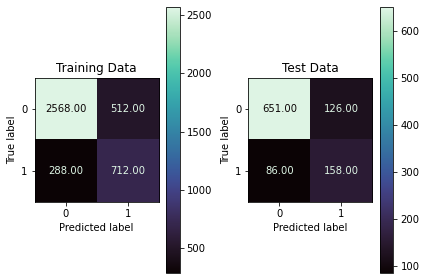

In [28]:
get_scores(svc_lin_grid, X_train, X_test, y_train, y_test, verbose=True)
get_class_report(svc_lin_grid, X_train, X_test, y_train, y_test)
ax1 = plt.subplot(121)
plot_confusion_matrix(svc_lin_grid, X_train, y_train, values_format='.2f', ax=ax1, cmap='mako')
plt.title('Training Data')

ax2 = plt.subplot(122)
plot_confusion_matrix(svc_lin_grid, X_test, y_test, values_format='.2f', ax=ax2, cmap='mako')
plt.title('Test Data')

plt.tight_layout()
plt.show()

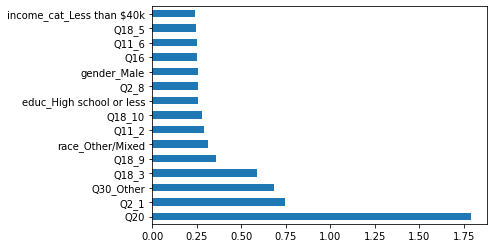

In [29]:
feature_svc_coef = pd.Series(abs(svc_lin_grid.best_estimator_.coef_[0]), index=X_train.columns)
feature_svc_coef.sort_values(ascending=False).nlargest(15).plot(kind='barh')
plt.show()

# Random Forest Classifier

To look how well the model fits and the `feature_importances`

In [30]:
params = {'max_depth': [5, 10, 15, 20], 'min_samples_split': [10, 25, 50], 'max_features': ['sqrt', 0.5, None]}

forest = RandomForestClassifier(criterion='entropy')

forest_grid = GridSearchCV(forest, param_grid = params, cv=5)

forest_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': ['sqrt', 0.5, None],
                         'min_samples_split': [10, 25, 50]})

In [31]:
forest_grid.best_params_

{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10}


Training Scores:
Score: 0.9375
Accuracy: 0.9375
Mean Squared Error: 0.0625
Mean Absolute Error: 0.0625

Test Scores:
Score: 0.8442703232125367
Accuracy: 0.8442703232125367
Mean Squared Error: 0.15572967678746327
Mean Absolute Error: 0.15572967678746327

Training Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      3080
           1       0.99      0.75      0.86      1000

    accuracy                           0.94      4080
   macro avg       0.96      0.88      0.91      4080
weighted avg       0.94      0.94      0.93      4080


Test Report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.91       777
           1       0.85      0.43      0.57       244

    accuracy                           0.84      1021
   macro avg       0.84      0.70      0.74      1021
weighted avg       0.84      0.84      0.82      1021



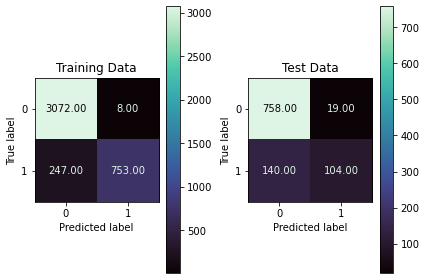

In [32]:
get_scores(forest_grid, X_train, X_test, y_train, y_test, verbose=True)
get_class_report(forest_grid, X_train, X_test, y_train, y_test)
ax1 = plt.subplot(121)
plot_confusion_matrix(forest_grid, X_train, y_train, values_format='.2f', ax=ax1, cmap='mako')
plt.title('Training Data')

ax2 = plt.subplot(122)
plot_confusion_matrix(forest_grid, X_test, y_test, values_format='.2f', ax=ax2, cmap='mako')
plt.title('Test Data')

plt.tight_layout()
plt.show()

In [33]:
forest_feature_importances = pd.DataFrame({'columns': X_train.columns, 'importance scores':forest_grid.best_estimator_.feature_importances_}).sort_values(
    by='importance scores', ascending=False)

forest_feature_importances.head(10)

,columns,importance scores
72,Q20,0.096332
74,ppage,0.087584
0,Q2_1,0.057714
73,Q25,0.030423
48,Q16,0.026222
1,Q2_2,0.021082
23,Q6,0.017297
37,Q9_4,0.016070
2,Q2_3,0.015644
35,Q9_2,0.014913


# Gradient Boosting Classifier

To look how well the model fits and the `feature_importances`

In [34]:
gbc = GradientBoostingClassifier(n_iter_no_change=100, n_estimators=10000)

params = {'learning_rate': np.arange(0.025, 0.125, 0.25),
          'max_depth': [3],
          'subsample': np.arange(0.4, 1.1,0.2),
          'max_features': [None, 'sqrt']}

gbc_grid = GridSearchCV(gbc, params, cv=3, scoring='f1', n_jobs=-1)

gbc_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(n_estimators=10000,
                                                  n_iter_no_change=100),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.025]), 'max_depth': [3],
                         'max_features': [None, 'sqrt'],
                         'subsample': array([0.4, 0.6, 0.8, 1. ])},
             scoring='f1')

In [35]:
gbc_grid.best_params_

{'learning_rate': 0.025,
 'max_depth': 3,
 'max_features': None,
 'subsample': 0.4}


Training Scores:
Score: 0.6937537901758641
Accuracy: 0.8762254901960784
Mean Squared Error: 0.12377450980392157
Mean Absolute Error: 0.12377450980392157

Test Scores:
Score: 0.6005089058524173
Accuracy: 0.8462291870714985
Mean Squared Error: 0.15377081292850148
Mean Absolute Error: 0.15377081292850148

Training Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      3080
           1       0.88      0.57      0.69      1000

    accuracy                           0.88      4080
   macro avg       0.88      0.77      0.81      4080
weighted avg       0.88      0.88      0.87      4080


Test Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.90       777
           1       0.79      0.48      0.60       244

    accuracy                           0.85      1021
   macro avg       0.82      0.72      0.75      1021
weighted avg       0.84      0.85      0.83      1021



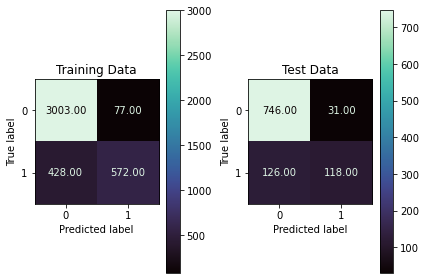

In [36]:
get_scores(gbc_grid, X_train, X_test, y_train, y_test, verbose=True)
get_class_report(gbc_grid, X_train, X_test, y_train, y_test)
ax1 = plt.subplot(121)
plot_confusion_matrix(gbc_grid, X_train, y_train, values_format='.2f', ax=ax1, cmap='mako')
plt.title('Training Data')

ax2 = plt.subplot(122)
plot_confusion_matrix(gbc_grid, X_test, y_test, values_format='.2f', ax=ax2, cmap='mako')
plt.title('Test Data')

plt.tight_layout()
plt.show()

In [37]:
gbc_feature_importances = pd.DataFrame({'columns': X_train.columns, 'importance scores':gbc_grid.best_estimator_.feature_importances_}).sort_values(
    by='importance scores', ascending=False)

gbc_feature_importances.head(10)

,columns,importance scores
72,Q20,0.263794
74,ppage,0.160120
0,Q2_1,0.075738
48,Q16,0.020107
55,Q18_3,0.018518
37,Q9_4,0.013947
73,Q25,0.013633
82,educ_High school or less,0.013253
1,Q2_2,0.012022
52,Q17_4,0.011681


# XGBoost Classifier

To look how well the model fits and the `feature_importances`

In [38]:
xgb = XGBClassifier(n_iter_no_change=50, n_estimators=1000)

params = {'learning_rate': np.arange(0.025, 0.125, 0.25),
          'max_depth': [3],
          'subsample': np.arange(0.4, 1.1,0.2),
          'max_features': [None, 'sqrt']}

xgb_grid = GridSearchCV(xgb, params, cv=3, scoring='f1', n_jobs=-1)

xgb_grid.fit(X_train, y_train)

[00:27:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_iter_no_change } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_iter_no_change=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=N

In [39]:
xgb_grid.best_params_

{'learning_rate': 0.025,
 'max_depth': 3,
 'max_features': None,
 'subsample': 0.4}


Training Scores:
Score: 0.7540202501488981
Accuracy: 0.8987745098039216
Mean Squared Error: 0.10122549019607843
Mean Absolute Error: 0.10122549019607843

Test Scores:
Score: 0.5944584382871536
Accuracy: 0.8423114593535749
Mean Squared Error: 0.15768854064642507
Mean Absolute Error: 0.15768854064642507

Training Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      3080
           1       0.93      0.63      0.75      1000

    accuracy                           0.90      4080
   macro avg       0.91      0.81      0.85      4080
weighted avg       0.90      0.90      0.89      4080


Test Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90       777
           1       0.77      0.48      0.59       244

    accuracy                           0.84      1021
   macro avg       0.81      0.72      0.75      1021
weighted avg       0.83      0.84      0.83      1021



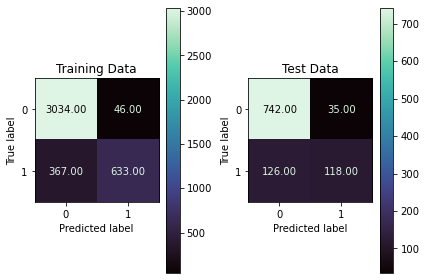

In [40]:
get_scores(xgb_grid, X_train, X_test, y_train, y_test, verbose=True)
get_class_report(xgb_grid, X_train, X_test, y_train, y_test)
ax1 = plt.subplot(121)
plot_confusion_matrix(xgb_grid, X_train, y_train, values_format='.2f', ax=ax1, cmap='mako')
plt.title('Training Data')

ax2 = plt.subplot(122)
plot_confusion_matrix(xgb_grid, X_test, y_test, values_format='.2f', ax=ax2, cmap='mako')
plt.title('Test Data')

plt.tight_layout()
plt.show()

In [41]:
xgb_feature_importances = pd.DataFrame({'columns': X_train.columns, 'importance scores':xgb_grid.best_estimator_.feature_importances_}).sort_values(
    by='importance scores', ascending=False)

xgb_feature_importances.head(10)

,columns,importance scores
72,Q20,0.093391
0,Q2_1,0.038451
74,ppage,0.016700
82,educ_High school or less,0.014988
55,Q18_3,0.014757
90,income_cat_Less than $40k,0.013982
48,Q16,0.013709
79,Q30_No preference,0.012590
77,Q24_Other,0.012034
68,Q19_6,0.011567


#Important Features

Take the top 10 features from each model to make a `best_features` list and run the model again to see how it fairs.

In [42]:
best_features = []

for feature in feature_svc_coef.nlargest(10).index:
  best_features.append(feature)

for feature in forest_feature_importances['columns'].head(10):
  if feature not in best_features:
    best_features.append(feature)

for feature in gbc_feature_importances['columns'].head(10):
  if feature not in best_features:
    best_features.append(feature)

for feature in xgb_feature_importances['columns'].head(10):
  if feature not in best_features:
    best_features.append(feature)

In [43]:
best_features

['Q20',
 'Q2_1',
 'Q30_Other',
 'Q18_3',
 'Q18_9',
 'race_Other/Mixed',
 'Q11_2',
 'Q18_10',
 'educ_High school or less',
 'Q2_8',
 'ppage',
 'Q25',
 'Q16',
 'Q2_2',
 'Q6',
 'Q9_4',
 'Q2_3',
 'Q9_2',
 'Q17_4',
 'income_cat_Less than $40k',
 'Q30_No preference',
 'Q24_Other',
 'Q19_6']

In [44]:
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

In [45]:
xgb = XGBClassifier(n_iter_no_change=50, n_estimators=1000)

params = {'learning_rate': np.arange(0.025, 0.125, 0.25),
          'max_depth': [3],
          'subsample': np.arange(0.4, 1.1,0.2),
          'max_features': [None, 'sqrt']}

xgb_best_grid = GridSearchCV(xgb, params, cv=3, scoring='f1', n_jobs=-1)

xgb_best_grid.fit(X_train_best, y_train)

[00:28:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_iter_no_change } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_iter_no_change=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=N

In [46]:
xgb_best_grid.best_params_

{'learning_rate': 0.025,
 'max_depth': 3,
 'max_features': None,
 'subsample': 0.4}


Training Scores:
Score: 0.6977589339794064
Accuracy: 0.8776960784313725
Mean Squared Error: 0.12230392156862745
Mean Absolute Error: 0.12230392156862745

Test Scores:
Score: 0.6188118811881188
Accuracy: 0.8491674828599413
Mean Squared Error: 0.15083251714005877
Mean Absolute Error: 0.15083251714005877

Training Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.92      3080
           1       0.88      0.58      0.70      1000

    accuracy                           0.88      4080
   macro avg       0.88      0.78      0.81      4080
weighted avg       0.88      0.88      0.87      4080


Test Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.91       777
           1       0.78      0.51      0.62       244

    accuracy                           0.85      1021
   macro avg       0.82      0.73      0.76      1021
weighted avg       0.84      0.85      0.84      1021



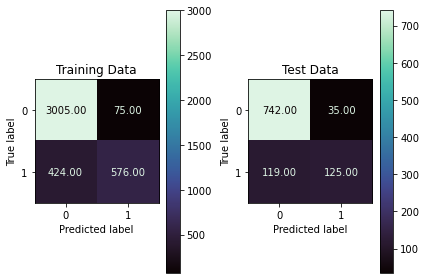

In [47]:
get_scores(xgb_best_grid, X_train_best, X_test_best, y_train, y_test, verbose=True)
get_class_report(xgb_best_grid, X_train_best, X_test_best, y_train, y_test)
ax1 = plt.subplot(121)
plot_confusion_matrix(xgb_best_grid, X_train_best, y_train, values_format='.2f', ax=ax1, cmap='mako')
plt.title('Training Data')

ax2 = plt.subplot(122)
plot_confusion_matrix(xgb_best_grid, X_test_best, y_test, values_format='.2f', ax=ax2, cmap='mako')
plt.title('Test Data')

plt.tight_layout()
plt.show()

In [48]:
smote = SMOTEENN(sampling_strategy=0.75)

X_train_best_samp, y_train_samp = smote.fit_resample(X_train_best, y_train)

In [49]:
xgb = XGBClassifier(n_iter_no_change=50, n_estimators=1000)

params = {'learning_rate': np.arange(0.025, 0.125, 0.25),
          'max_depth': [3],
          'subsample': np.arange(0.4, 1.1,0.2),
          'max_features': [None, 'sqrt']}

xgb_best_samp_grid = GridSearchCV(xgb, params, cv=3, scoring='f1', n_jobs=-1)

xgb_best_samp_grid.fit(X_train_best_samp, y_train_samp)

[00:28:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_iter_no_change } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_iter_no_change=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=N

In [50]:
xgb_best_samp_grid.best_params_

{'learning_rate': 0.025,
 'max_depth': 3,
 'max_features': None,
 'subsample': 0.4}


Training Scores:
Score: 0.9650014956625785
Accuracy: 0.9652818991097922
Mean Squared Error: 0.034718100890207715
Mean Absolute Error: 0.034718100890207715

Test Scores:
Score: 0.5988700564971751
Accuracy: 0.791380999020568
Mean Squared Error: 0.20861900097943192
Mean Absolute Error: 0.20861900097943192

Training Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      1671
           1       0.98      0.95      0.97      1699

    accuracy                           0.97      3370
   macro avg       0.97      0.97      0.97      3370
weighted avg       0.97      0.97      0.97      3370


Test Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86       777
           1       0.55      0.65      0.60       244

    accuracy                           0.79      1021
   macro avg       0.72      0.74      0.73      1021
weighted avg       0.81      0.79      0.80      1021



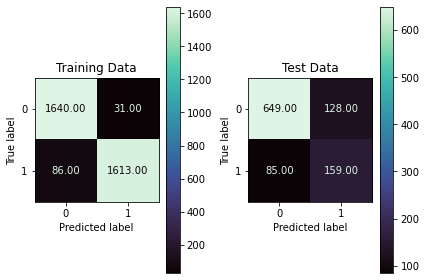

In [53]:
get_scores(xgb_best_samp_grid, X_train_best_samp, X_test_best, y_train_samp, y_test, verbose=True)
get_class_report(xgb_best_samp_grid, X_train_best_samp, X_test_best, y_train_samp, y_test)
ax1 = plt.subplot(121)
plot_confusion_matrix(xgb_best_samp_grid, X_train_best_samp, y_train_samp, values_format='.2f', ax=ax1, cmap='mako')
plt.title('Training Data')

ax2 = plt.subplot(122)
plot_confusion_matrix(xgb_best_samp_grid, X_test_best, y_test, values_format='.2f', ax=ax2, cmap='mako')
plt.title('Test Data')

plt.tight_layout()
plt.show()

# Conclusion

No one model truly out performed the others in this testing. Each did fairly well to predict the test set with test accuracies of 0.84 for all but the SVC model (which got 0.8). However, accuracy isn't everything and the recall for most of the model suffer due to the class imbalance of the data set. When trying to account for this with resampling, the precision decreases drastically for the models. So, depending on which is most important, recall or precision, either method could be used.

Besides the demographic values that clearly matter when it comes to determining whether someone will vote or not, with age being clearly the most important of these features, there were a few features that appeared in each of the model's feature_importances lists. 

The most important of these, unsurprisingly, is `Q20`, which is whether someone has registered to vote or not. Clearly it goes without saying that being registered is a very important metric for voter turnout. Clearly having more incentives to ensure people are registered to vote is in order. 

`Q18_3` is similar to this as it shows those who missed voting registration deadlines.

`Q2_1` asked the respondants how important the elections are. `Q25` askes how much they paid attention to the election. So, having an interest and understanding how important the elections are is an indicator of someone interest in voting.

`Q16` is an interesting question, as it asks how easy or difficult it is to vote. So, efforts in making voting easier could greatly influence voter turnout, or at least changing people impressions of its difficulty could. 

